# DAG Example: Map-Reduce word count

This example DAG consists of counting the words of some books available for free at the [Gutenberg Project website](https://www.gutenberg.org). To do so, a Map task counts the words in parallel by splitting the texts in chunks. Then, for every book all the words counted are merged and reduced in a single function.

#### Prerequisites to run this example:

In order to run this example, you will need:

- An IBM Cloud Functions account. You can register for free and access the IBM Cloud Functions free tier [here](https://www.ibm.com/cloud/free).


- The example functions provided deployed in IBM Cloud Functions using Triggerflow's runtime that sends the termination event. To do so, you need the IBM Cloud CLI installed. Create a new package and deploy the two functions needed for this example:

```
$ ibmcloud wsk package create triggerflow-examples

$ ibmcloud wsk action create triggerflow-examples/count-words --docker triggerflow/ibm_cloud_functions_runtime examples/dag-example/count_words.py

$ ibmcloud wsk action create triggerflow-examples/merge-dicts --docker triggerflow/ibm_cloud_functions_runtime examples/dag-example/merge_dicts.py
```

- A Triggerflow installation up and running. Please refer to the installation guide to properly install a Triggerflow instance.

## DAG Definition

The cell below descirbes the DAG tasks and dependencies. Similarly to Airflow's DAG definition, a Triggerflow DAG is composed of multiple operators that describe how or where a task is executed. In this case, we are executing serverless functions on IBM Cloud. The bitwise shift operator is used to set the task order of execution. For example, here the `count_*` tasks will be executed before the `merge_*` tasks. The `merge_*` are getting a JSONPath as value for the parameter `dicts`. This JSONPath is used to pass the data from a task to a following one. The JSONPath is parsed and evaluated in runtime when the task is being prepared to be run. In this case, with `$.[*]`, we are getting all the elements from the array of results that the `count_*` tasks generate.

In [1]:
from triggerflow.dags import DAG
from triggerflow.dags.operators import IBMCloudFunctionsCallAsyncOperator, IBMCloudFunctionsMapOperator

urls = ['http://www.gutenberg.org/files/2701/2701-0.txt',
        'http://www.gutenberg.org/files/1661/1661-0.txt',
        'http://www.gutenberg.org/files/84/84-0.txt']

# urls = ['http://www.gutenberg.org/files/2701/2701-0.txt']

dag = DAG('count-words')
parallel = 8

for i, url in enumerate(urls):
    count = IBMCloudFunctionsMapOperator(
        task_id='count_{}'.format(i),
        function_name='count-words',
        function_package='triggerflow-examples',
        invoke_kwargs={'url': url,
                       'parallel': parallel},
        iter_data=('func_id', [par for par in range(parallel)]),
        dag=dag)
    
    merge = IBMCloudFunctionsCallAsyncOperator(
        task_id='merge_{}'.format(i),
        function_name='merge-dicts',
        function_package='triggerflow-examples',
        invoke_kwargs={'dicts': '$.[*]'.format(i)},
        dag=dag)
    
    count >> merge

We can visualize the DAG tasks and order of execution using `dag.show()`, which uses Grpahviz as backend to plot the graph image for now.

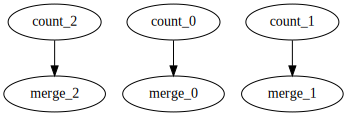

In [2]:
dag.show()

Triggerlfow allows to save DAGs in a local folder of this system. By doing so, we could trigger a DAG execution without having to redeclare the whole DAG object as before. Triggerflow stores its DAGs in JSON format.

In [3]:
dag.save()

some_new_dag_object = DAG('count-words')
some_new_dag_object.load()
some_new_dag_object.tasks

## DAG execution

We can trigger a DAG exection using the `dag.run()` method. This will create a DAGRun object, with a unique ID of execution. The DAGRun object, when it is instantiated, it registers all the triggers neccessary to orchestarte the DAG, and publishes the initial CloudEvent to the event source, so that the DAG starts executing right away.

In [4]:
dagrun = dag.run()

DAG Run ID: count-words-f123c4dc5bd2


The `dagrun.result()` gets the result of the final task. The result are the `data` values from the events that activated the final join trigger. A task_id can be passed as parameter to retrieve the results from any other task in the DAG. However, this method call does not block until the DAG execution is completed, so it might raise an exception if the results aren't yet available.

In [5]:
result = dagrun.result()
result

[{'But': 24,
  'Chapter': 26,
  'Gutenberg-tm': 53,
  'He': 50,
  'I': 2719,
  'M.': 21,
  'My': 26,
  'Project': 76,
  'She': 22,
  'The': 247,
  'a': 1394,
  'all': 136,
  'am': 21,
  'an': 195,
  'and': 2971,
  'any': 41,
  'are': 127,
  'as': 486,
  'at': 304,
  'be': 357,
  'been': 123,
  'before': 25,
  'but': 542,
  'by': 466,
  'can': 24,
  'could': 160,
  'do': 28,
  'electronic': 27,
  'first': 23,
  'for': 484,
  'found': 30,
  'from': 387,
  'had': 679,
  'have': 340,
  'he': 448,
  'her': 300,
  'him': 59,
  'his': 500,
  'if': 88,
  'in': 1125,
  'into': 27,
  'is': 322,
  'it': 372,
  'its': 50,
  'man': 27,
  'may': 56,
  'me': 529,
  'me,': 78,
  'might': 38,
  'more': 48,
  'my': 1631,
  'no': 96,
  'not': 498,
  'now': 21,
  'of': 2741,
  'old': 24,
  'on': 435,
  'one': 130,
  'or': 190,
  'our': 68,
  'saw': 24,
  'shall': 24,
  'she': 122,
  'should': 95,
  'so': 131,
  'some': 68,
  'that': 987,
  'the': 4056,
  'their': 99,
  'these': 47,
  'they': 87,
  'this':

DAGRuns are also stored in the local system's Triggerflow cache. This is useful for long running DAG executions, because the state of the workflow can be retreived without having to maintain instantiated the DAGRun object. To load a run, the ID is required.

In [7]:
from triggerflow.dags import DAGRun

same_run = DAGRun.load_run('count-words-f123c4dc5bd2')
res = same_run.result()
print(res)


[{'But': 24, 'Chapter': 26, 'Gutenberg-tm': 53, 'He': 50, 'I': 2719, 'M.': 21, 'My': 26, 'Project': 76, 'She': 22, 'The': 247, 'a': 1394, 'all': 136, 'am': 21, 'an': 195, 'and': 2971, 'any': 41, 'are': 127, 'as': 486, 'at': 304, 'be': 357, 'been': 123, 'before': 25, 'but': 542, 'by': 466, 'can': 24, 'could': 160, 'do': 28, 'electronic': 27, 'first': 23, 'for': 484, 'found': 30, 'from': 387, 'had': 679, 'have': 340, 'he': 448, 'her': 300, 'him': 59, 'his': 500, 'if': 88, 'in': 1125, 'into': 27, 'is': 322, 'it': 372, 'its': 50, 'man': 27, 'may': 56, 'me': 529, 'me,': 78, 'might': 38, 'more': 48, 'my': 1631, 'no': 96, 'not': 498, 'now': 21, 'of': 2741, 'old': 24, 'on': 435, 'one': 130, 'or': 190, 'our': 68, 'saw': 24, 'shall': 24, 'she': 122, 'should': 95, 'so': 131, 'some': 68, 'that': 987, 'the': 4056, 'their': 99, 'these': 47, 'they': 87, 'this': 335, 'to': 2142, 'towards': 27, 'upon': 42, 'very': 21, 'was': 993, 'we': 69, 'were': 277, 'what': 22, 'when': 262, 'which': 547, 'who': 55, 